Annie Taylor
2.14.23

### Analyzing Field Data - Regressions

In [2]:
import pandas as pd
import numpy as np
import os
import csv
import datetime as dt
from IPython.display import display
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)

import altair as alt
import altair_saver
import statsmodels.api as sm
import statsmodels.stats.multicomp
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats
import scikit_posthocs as sp
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from scipy.special import expit, logit
from sklearn.metrics import r2_score
import seaborn as sns

import matplotlib.pyplot as plt
# reset to default rcParams for matplotlib
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

# change matplotlib default display options
# plt.rcParams.update({'font.size': 16})
# plt.style.use('ggplot') # I like 'ggplot' and 'seaborn-colorblind'
# plt.rcParams['font.family'] = 'Calibri'

#### Import data

This CSV is exported from Pro with extracted values

In [3]:
file = 'D:/1_AMLT/7_CascadeBiodiversity/Plot_Data_Working_0523_added_PROexport.csv'
data = pd.read_csv(file)
# display(data)

### Select plant or group for analysis


In [4]:
testcol = 'P_DACA'
# testcol = 'CB_dBAI_10_6'
# testcol = 'SL_NatShrub'

### Average Fire Severity of plots

In [5]:
data.groupby('Site').mean(numeric_only=True)

,OID_,PlotNum,ACMI,BAPI,CHPO,DACA,FRCA,MASA,PHAQ,PLLA,RUUR,HOLA,BRMA,esrignss_longitude,esrignss_latitude,CZU_dBAI_10_6,CB_dBAI_10_6,CZU_dNBR,CB_dNBR,Cultural,Native,Invasive,Shrubs,Herbaceous,P_ACMI,P_BAPI,P_CHPO,P_DACA,P_FRCA,P_MASA,P_PHAQ,P_PLLA,P_RUUR,P_HOLA,P_BRMA,CountCultural,CountNative,CountInvasive,CountShrubs,CountHerbaceous,TotalSpeciesCount,SpeciesListCount,SL_Cultural,SL_Native,SL_Invasive,SL_NatHerb,SL_NatShrub,NearestTrail,NearestAg,DistHwy1,DistOcean,SSURGO_SoilType,Plot_Dist_Change,FullCover,CB_dBAI_Resample_1,CZU_dBAI_Resample_1,CB_RBR,CZU_RBR
Site,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CZU,60.048780,61.195122,0.000000,2.317073,0.365854,15.243902,0.243902,0.000000,10.609756,4.024390,0.975610,4.024390,0.000000,-122.334811,37.141088,-0.990519,0.338614,0.432019,-0.021527,16.829268,19.146341,18.658537,3.536585,34.268293,0.00000,0.268293,0.02439,0.585366,0.024390,0.00000,0.585366,0.463415,0.097561,0.414634,0.000000,0.731707,1.000000,1.463415,0.390244,2.073171,2.463415,5.975610,0.731707,1.878049,3.780488,1.341463,0.390244,171.430206,415.041736,409.759241,555.495288,7.487805,2.913769,37.804878,0.338438,-0.983796,-0.043456,0.421620
NO,95.195122,95.536585,0.365854,19.878049,0.000000,1.341463,3.902439,0.000000,22.560976,0.609756,10.853659,2.073171,1.829268,-122.349208,37.148633,-0.093001,0.093064,0.184744,-0.008522,16.463415,36.341463,27.073171,34.634146,28.780488,0.04878,0.585366,0.00000,0.073171,0.146341,0.00000,0.658537,0.097561,0.609756,0.195122,0.219512,0.878049,1.463415,1.170732,1.341463,1.292683,2.634146,5.804878,0.829268,2.146341,3.512195,0.707317,1.292683,115.265087,1624.648317,191.712419,265.153561,13.097561,7.845168,63.414634,0.097774,-0.092365,-0.008909,0.149010
RX,32.976190,32.166667,0.238095,0.952381,0.119048,11.071429,0.000000,0.833333,0.714286,11.309524,2.500000,2.380952,0.000000,-122.340106,37.143346,-0.143620,-0.589502,0.210658,0.162706,14.761905,15.714286,14.404762,3.452381,26.666667,0.02381,0.047619,0.02381,0.547619,0.000000,0.02381,0.071429,0.666667,0.071429,0.190476,0.000000,0.690476,0.738095,0.928571,0.119048,1.547619,1.666667,4.880952,0.690476,1.404762,3.071429,1.214286,0.142857,145.863632,935.742149,355.987343,314.543556,7.000000,1.468061,30.119048,-0.557431,-0.139155,0.214580,0.213001


### Boxplot of percent cover values

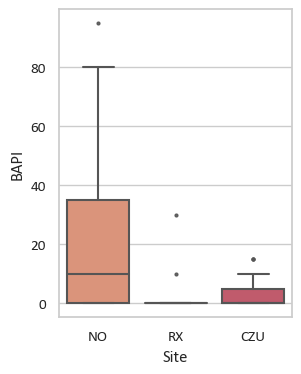

In [5]:
plant = 'BAPI'

sns.set_theme(style='whitegrid', palette='flare', font='Calibri')
fig, ax = plt.subplots(figsize=(3,4))
ax = sns.boxplot(data=data,
                 x='Site',
                 y=plant,
                 flierprops = {'marker': 'o', 'markersize':2, 'alpha':0.9},
                 order=['NO', 'RX', 'CZU']
                )
plt.show()

### Figure 2 of the manuscript - percent cover of four species

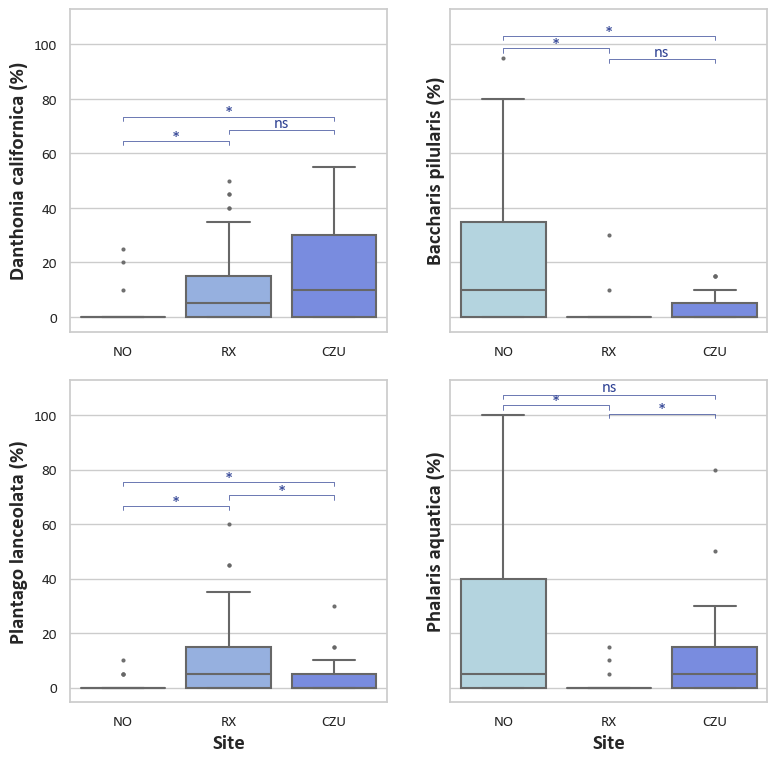

In [6]:
sns.set_theme(style='whitegrid', palette='blend:lightblue,blue', font='Calibri')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9), sharey=True) #constrained_layout = True, sharex=True)

sns.boxplot(ax=ax1, data=data, x='Site', y='DACA', flierprops = {'marker': 'o', 'markersize':2, 'alpha':0.9}, order=['NO', 'RX', 'CZU'])
sns.boxplot(ax=ax2, data=data, x='Site', y='BAPI', flierprops = {'marker': 'o', 'markersize':2, 'alpha':0.9}, order=['NO', 'RX', 'CZU'])
sns.boxplot(ax=ax3, data=data, x='Site', y='PLLA', flierprops = {'marker': 'o', 'markersize':2, 'alpha':0.9}, order=['NO', 'RX', 'CZU'])
sns.boxplot(ax=ax4, data=data, x='Site', y='PHAQ', flierprops = {'marker': 'o', 'markersize':2, 'alpha':0.9}, order=['NO', 'RX', 'CZU'])

ax1.set_ylabel('Danthonia californica (%)', fontweight ='bold', size = 15)
ax2.set_ylabel('Baccharis pilularis (%)', fontweight ='bold', size = 15)
ax3.set_ylabel('Plantago lanceolata (%)', fontweight ='bold', size = 15)
ax4.set_ylabel('Phalaris aquatica (%)', fontweight ='bold', size = 15)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('Site', fontweight='bold', size = 15)
ax4.set_xlabel('Site', fontweight='bold', size = 15)
plt.subplots_adjust(hspace=0.15)

##########################################################

# STATISTICAL ANNOTATIONS
x1, x2, x3 = 0, 1, 2 # no, rx, czu 
# y1, y2, y3 = 97, 93, 101.5
h, col, mark = 1.5, '#2f4294', '#2f4294'
# DACA
y1, y2, y3 = 63, 67, 72
# no vs rx
ax1.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=0.5, c=col) #plot the bar line
ax1.text((x1+x2)*.5, y1, '*', ha='center', va='bottom', color=mark) #add the text
# rx vs czu
ax1.plot([x2, x2, x3, x3], [y2, y2+h, y2+h, y2], lw=0.5, c=col)
ax1.text((x2+x3)*.5, y2+1.5, 'ns', ha='center', va='bottom', color=mark)
# no vs czu
ax1.plot([x1, x1, x3, x3], [y3, y3+h, y3+h, y3], lw=0.5, c=col)
ax1.text((x1+x3)*.5, y3, '*', ha='center', va='bottom', color=mark)

# BAPI
y1, y2, y3 = 97, 93, 101.5
# no vs rx
ax2.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=0.5, c=col) 
ax2.text((x1+x2)*.5, y1, '*', ha='center', va='bottom', color=mark) 
# rx vs czu
ax2.plot([x2, x2, x3, x3], [y2, y2+h, y2+h, y2], lw=0.5, c=col)
ax2.text((x2+x3)*.5, y2+1.5, 'ns', ha='center', va='bottom', color=mark)
# no vs czu
ax2.plot([x1, x1, x3, x3], [y3, y3+h, y3+h, y3], lw=0.5, c=col)
ax2.text((x1+x3)*.5, y3, '*', ha='center', va='bottom', color=mark)

# PLLA
y1, y2, y3 = 65, 69, 74
# no vs rx
ax3.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=0.5, c=col)
ax3.text((x1+x2)*.5, y1, '*', ha='center', va='bottom', color=mark)
# rx vs czu
ax3.plot([x2, x2, x3, x3], [y2, y2+h, y2+h, y2], lw=0.5, c=col)
ax3.text((x2+x3)*.5, y2, '*', ha='center', va='bottom', color=mark)
# no vs czu
ax3.plot([x1, x1, x3, x3], [y3, y3+h, y3+h, y3], lw=0.5, c=col)
ax3.text((x1+x3)*.5, y3, '*', ha='center', va='bottom', color=mark)

# PHAQ
y1, y2, y3 = 102, 99, 106
# no vs rx
ax4.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=0.5, c=col) 
ax4.text((x1+x2)*.5, y1, '*', ha='center', va='bottom', color=mark)
# rx vs czu
ax4.plot([x2, x2, x3, x3], [y2, y2+h, y2+h, y2], lw=0.5, c=col)
ax4.text((x2+x3)*.5, y2, '*', ha='center', va='bottom', color=mark)
# no vs czu
ax4.plot([x1, x1, x3, x3], [y3, y3+h, y3+h, y3], lw=0.5, c=col)
ax4.text((x1+x3)*.5, y3+1.5, 'ns', ha='center', va='bottom', color=mark)

# filename = 'D:/1_AMLT/7_CascadeBiodiversity/Maps_Figures/Figure5_PercentCoverBoxPlots.png'
# plt.savefig(filename, format="png", dpi=600)

plt.show()

#### Create combined fire severity columns that correspond to the right fire event for each site
Severity on the no fire site is the average of the two fire events

In [13]:
def RBR_calc(df):
    if df['Site'] == 'CZU':
        return df['CZU_RBR']
    elif df['Site'] == 'RX':
        return df['CB_RBR']
    else: #for no fire, return the mean of both fires
        return (df['CZU_RBR'] + df['CB_RBR'])/2

data['RBR'] = data.apply(RBR_calc, axis=1)
# display(data)
# data.groupby('Site').mean(numeric_only=True)

#### Boxplot of fire severity (RBR) on all plots

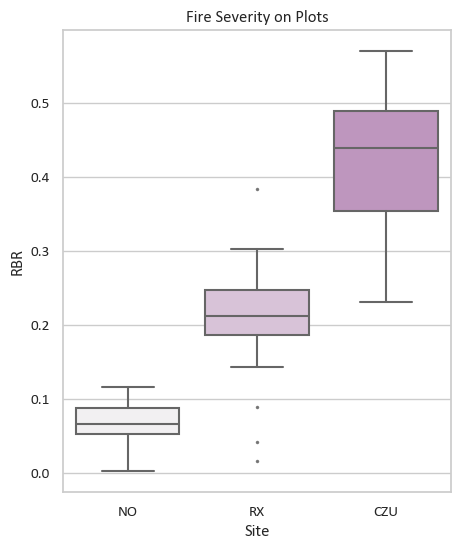

In [14]:
sns.set_theme(style='whitegrid', palette='light:purple', font='Calibri')
fig, ax = plt.subplots(figsize=(5,6))
ax = sns.boxplot(data=data,
                 x='Site',
                 y='RBR',
                 flierprops = {'marker': 'o', 'markersize':1.5, 'alpha':0.8},
                 order=['NO', 'RX', 'CZU']
                ).set(title='Fire Severity on Plots')
plt.show()

#### Chi Squared Test

In [17]:
# Create a df with just counts of a given plant
# not running it on plants with total occurrences fewer than 15
plants = ['P_FRCA','P_BAPI','P_DACA','P_HOLA','P_PHAQ','P_PLLA','P_RUUR']

for plant in plants: 
    counts = data.groupby('Site').sum(numeric_only=True)[plant]
    print(plant[2:] + ' occurences: \n', counts)

    # Perform the chi-squared test, expected values are uniformly distributed
    chi2, p_value = stats.chisquare(counts)

    print(f"Chi-squared statistic: {chi2}")
#     print(f"P-value: {p_value}")
    if p_value < 0.05:
        print(f'Significant diff with p-value: {p_value:.5f}')
    else:
        print(f'NOT a significant diff, p-value: {p_value:.5f}')
    print('\n\n')

FRCA occurences: 
 Site
CZU    1
NO     6
RX     0
Name: P_FRCA, dtype: int64
Chi-squared statistic: 8.857142857142856
Significant diff with p-value: 0.01193



BAPI occurences: 
 Site
CZU    11
NO     24
RX      2
Name: P_BAPI, dtype: int64
Chi-squared statistic: 19.83783783783784
Significant diff with p-value: 0.00005



DACA occurences: 
 Site
CZU    24
NO      3
RX     23
Name: P_DACA, dtype: int64
Chi-squared statistic: 16.839999999999996
Significant diff with p-value: 0.00022



HOLA occurences: 
 Site
CZU    17
NO      8
RX      8
Name: P_HOLA, dtype: int64
Chi-squared statistic: 4.909090909090909
NOT a significant diff, p-value: 0.08590



PHAQ occurences: 
 Site
CZU    24
NO     27
RX      3
Name: P_PHAQ, dtype: int64
Chi-squared statistic: 19.0
Significant diff with p-value: 0.00007



PLLA occurences: 
 Site
CZU    19
NO      4
RX     28
Name: P_PLLA, dtype: int64
Chi-squared statistic: 17.294117647058822
Significant diff with p-value: 0.00018



RUUR occurences: 
 Site
CZU 

## Logistic Regression

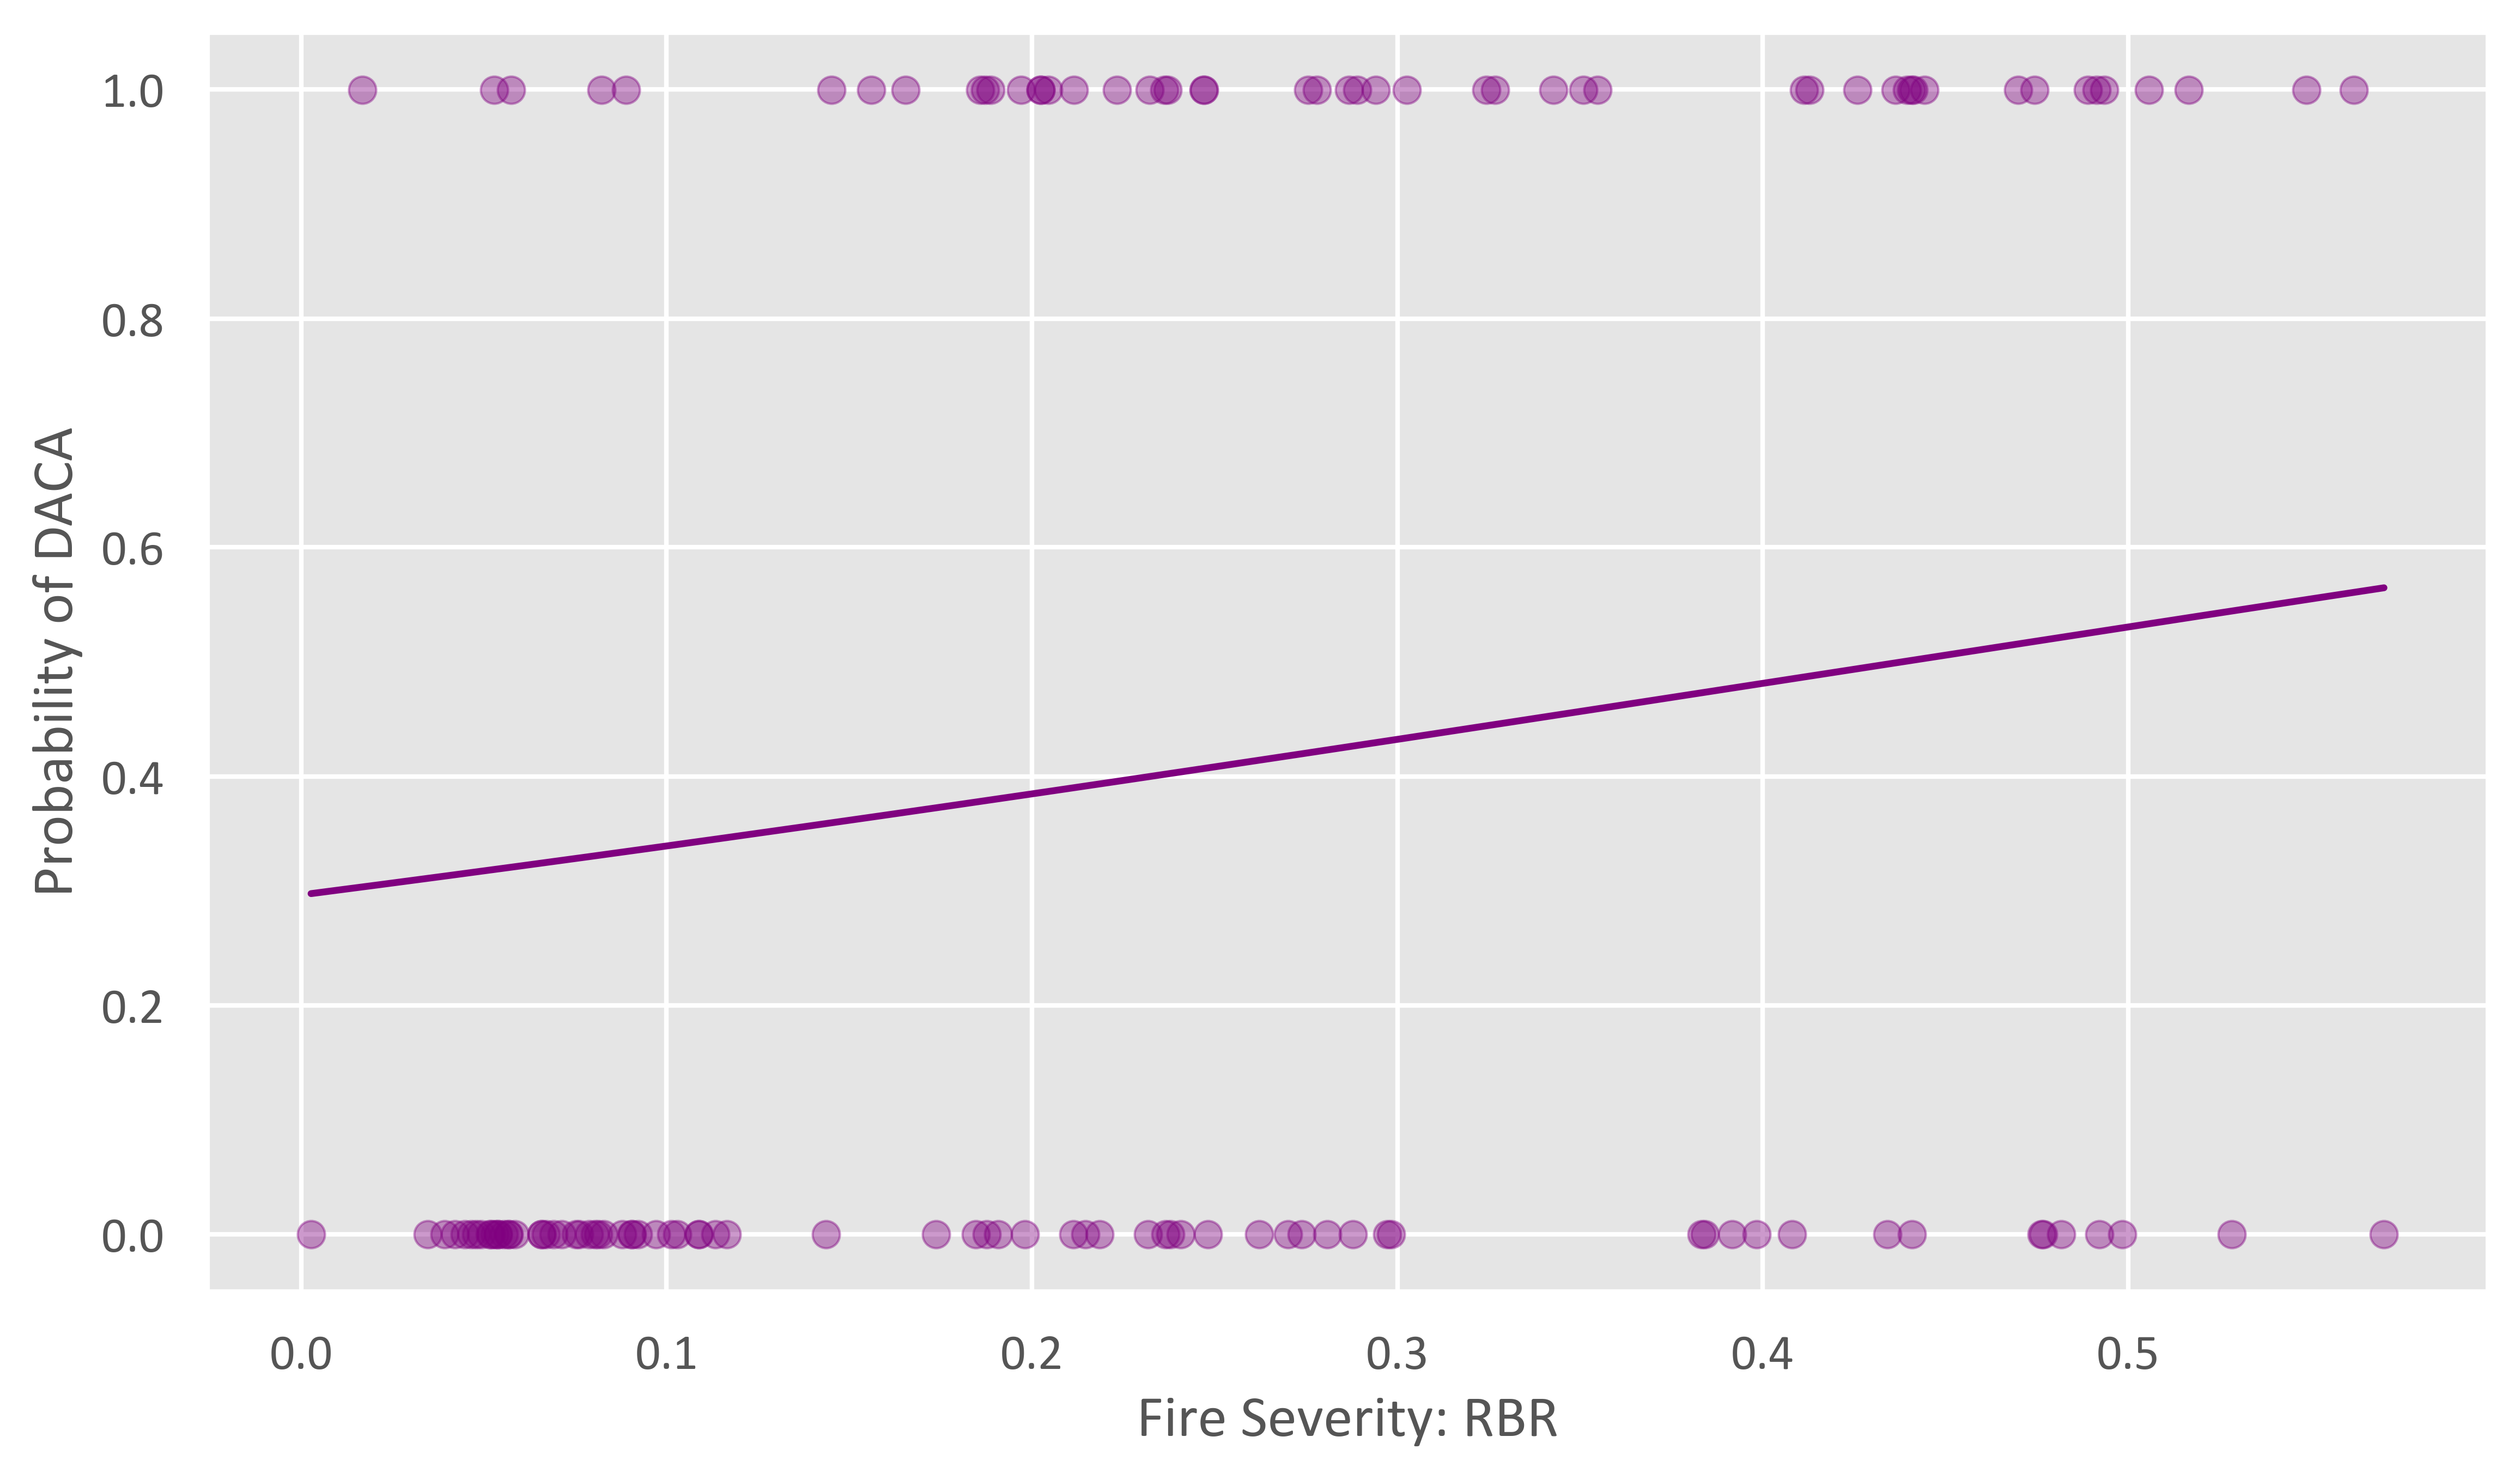

In [22]:
plt.style.use('ggplot') # I like 'ggplot' and 'seaborn-colorblind'
plt.rcParams['font.family'] = 'Calibri'

# all possible plants
c_native = ['P_ACMI', 'P_BAPI', 'P_CHPO', 'P_DACA', 'P_FRCA', 'P_MASA', 'P_RUUR']
c_invasive = ['P_PHAQ', 'P_PLLA', 'P_HOLA', 'P_BRMA']

# Fit a logistic regression model to the data
fire = 'RBR'
plant = 'P_DACA'

X = data[[fire]]
Y = data[plant]

logmodel = LogisticRegression()
logmodel.fit(X, Y)

# to plot the logistic probability curve
X_test = np.linspace(X.min(), X.max(), 300)
loss = expit(X_test * logmodel.coef_ + logmodel.intercept_).ravel()

plt.figure(figsize=(9,5), dpi=600)
plt.plot(X_test, loss, label='Logistic Regression Model', color='purple', linewidth=1.5)

# another way to plot LP curve as points 
# plt.scatter(X_test, logmodel.predict_proba(X_test)[:,1])

# Matplotlib logistic regression
plt.scatter(X, Y, color='purple', alpha=0.4)
plt.xlabel(f'Fire Severity: {fire}', fontsize=13)
plt.ylabel(f'Probability of {plant[2:]}', fontsize=13)
plt.show()

### Linear Regression
For each fire site individually and combined

Controlled burn
                             OLS Regression Results                            
Dep. Variable:                   PHAQ   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6132
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.438
Time:                        14:51:02   Log-Likelihood:                -102.47
No. Observations:                  42   AIC:                             208.9
Df Residuals:                      40   BIC:                             212.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3859      1.472   

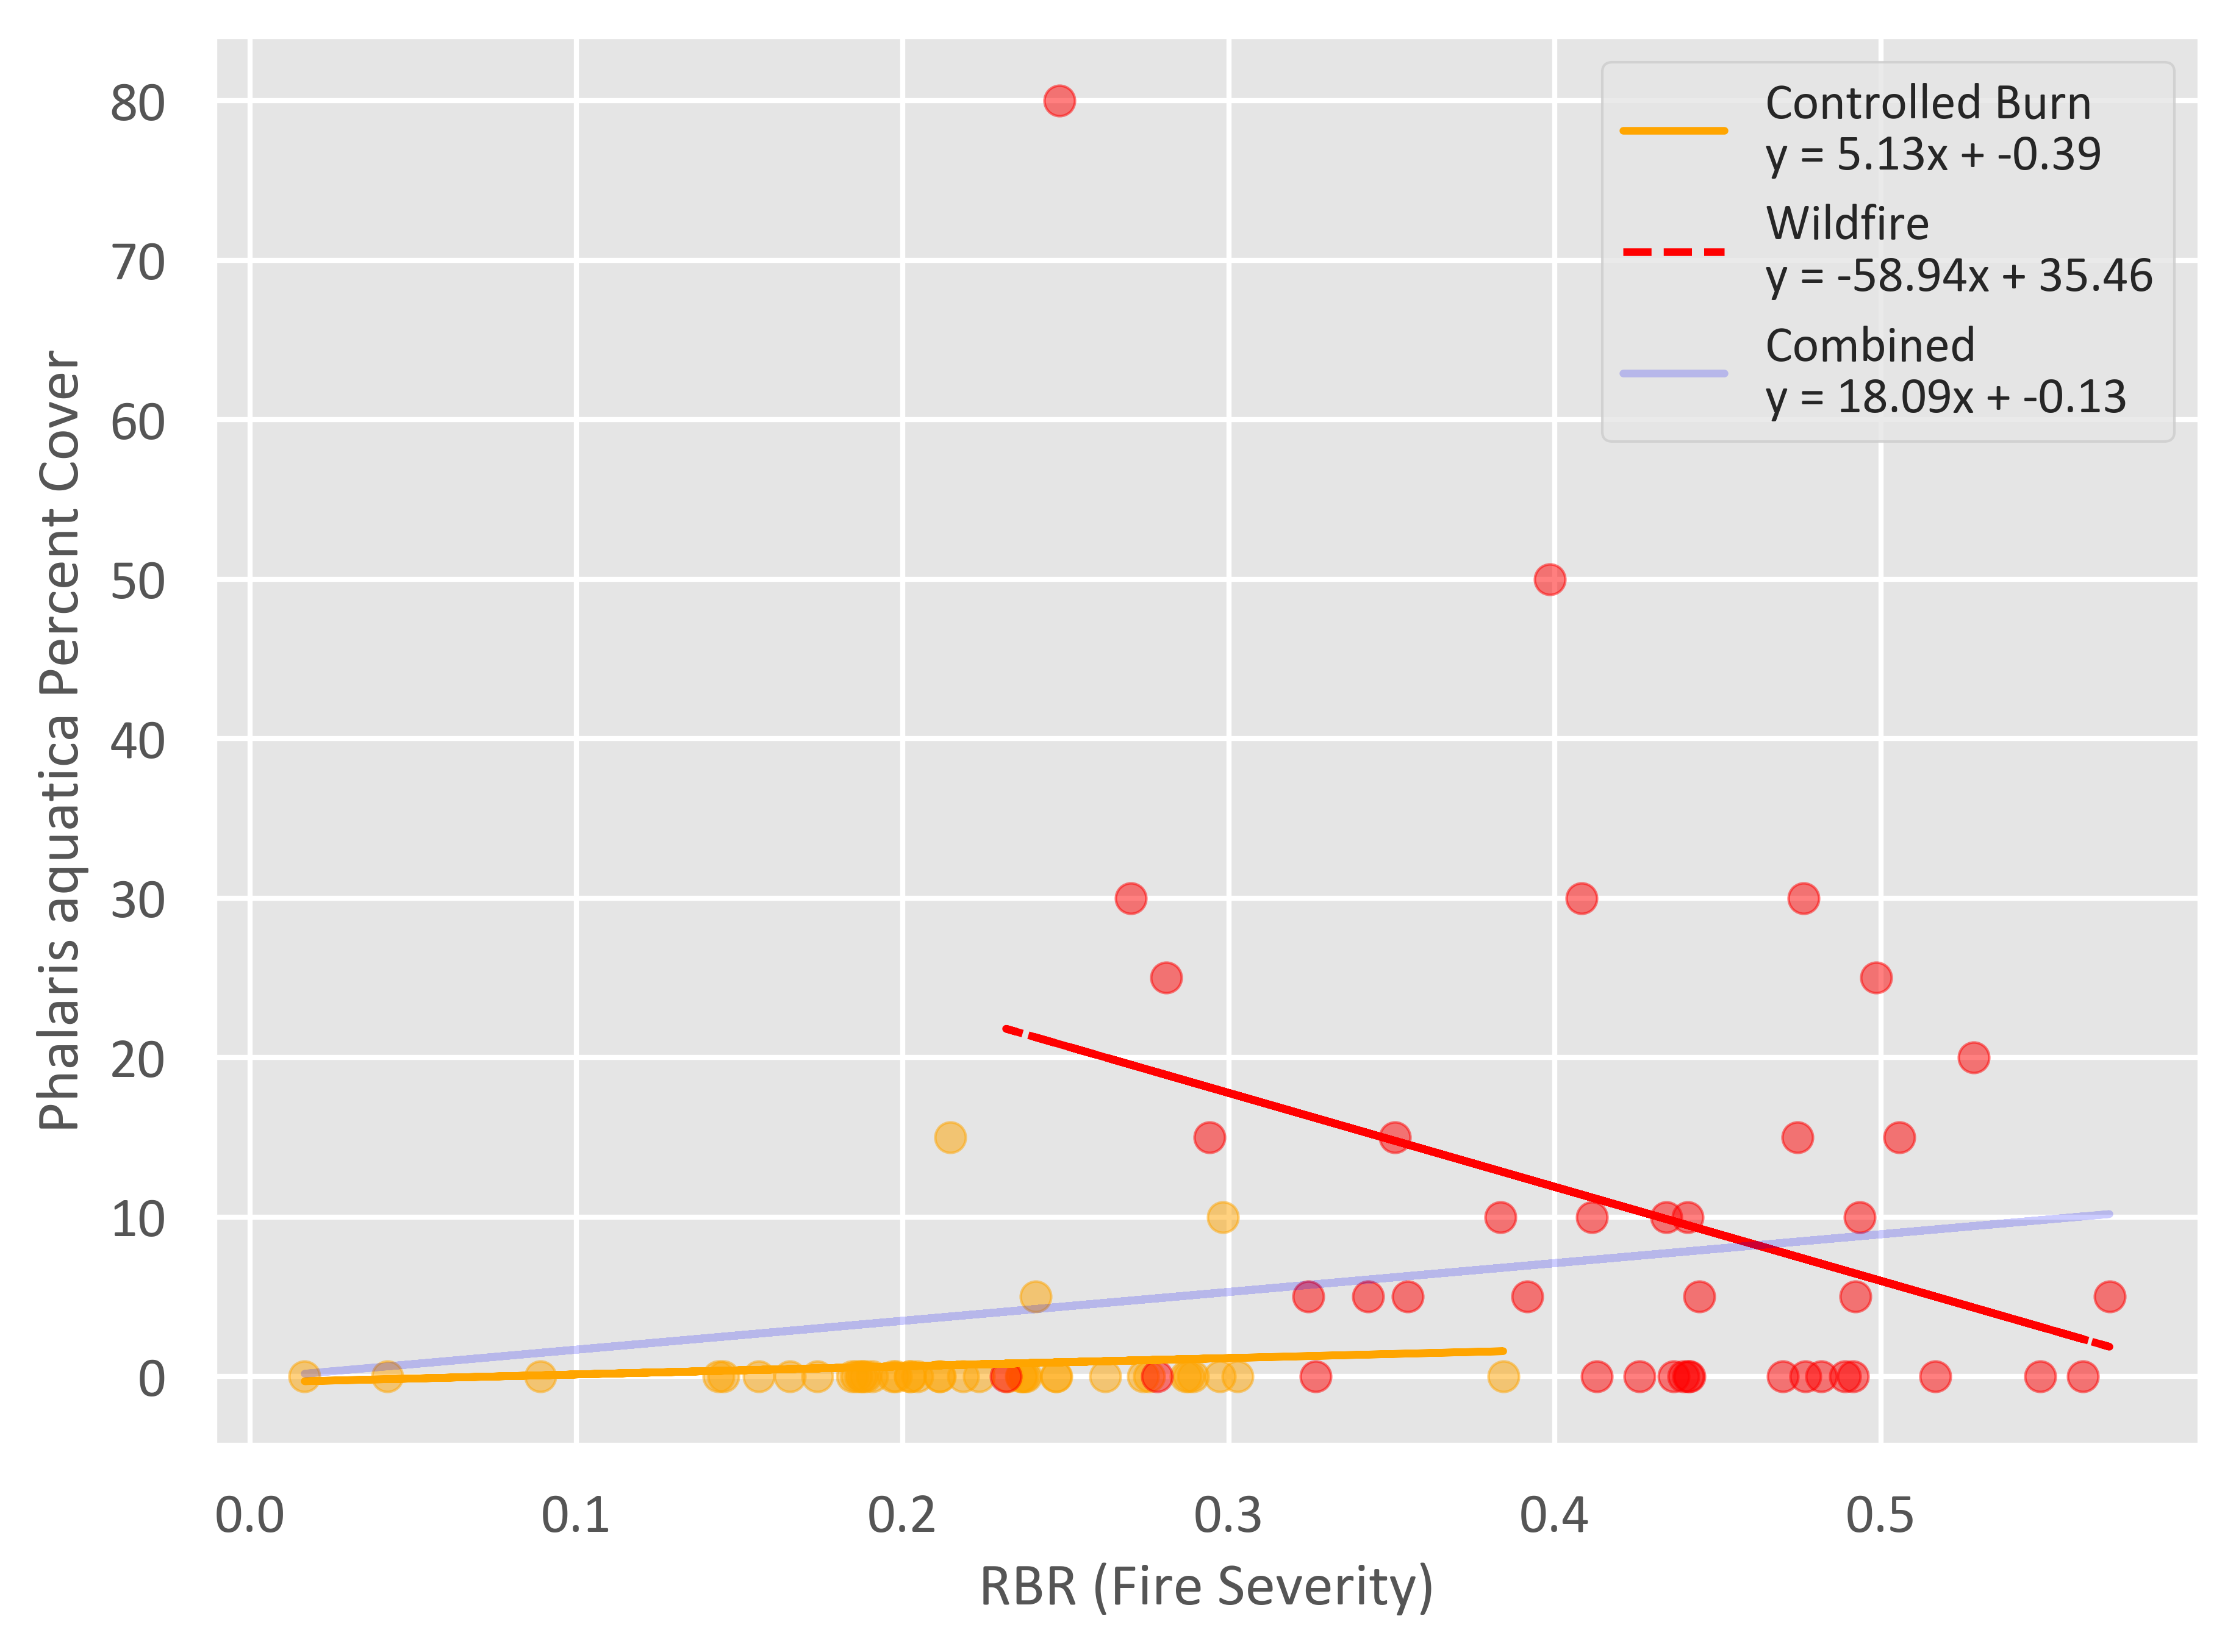

In [23]:
plt.style.use('ggplot') # I like 'ggplot' and 'seaborn-colorblind'
plt.rcParams['font.family'] = 'Calibri'

# make fire dfs
rxfire = data.loc[data['Site'] == 'RX']
wildfire = data.loc[data['Site'] == 'CZU']
nofire = data.loc[data['Site'] == 'NO']
allfire = data.loc[data['Site'] != 'NO']

# not running it on plants with total occurrences fewer than 15
# display(allfire.groupby('Site').sum()) # BAPI is only 13, decided to exclude 
plants = ['DACA','HOLA','PHAQ','PLLA']
plantnames = ['Danthonia californica','Holcus lanatus','Phalaris aquatica','Plantago lanceolata']
number = 2 # 0 to 3 to pick a plant

# Fit a linear regression model to the data
fire = 'RBR'
plant = plants[number]
plantlabel = plantnames[number]

# get two sets of Xs and Ys to plot on same plot
X1 = rxfire[fire]
y1 = rxfire[plant]
X2 = wildfire[fire]
y2 = wildfire[plant]
X = allfire[fire]
y = allfire[plant]

model1 = sm.OLS(y1, sm.add_constant(X1)).fit()
model2 = sm.OLS(y2, sm.add_constant(X2)).fit()
modelall = sm.OLS(y, sm.add_constant(X)).fit()

# Print a summary of the regression results
print('Controlled burn\n', model1.summary())
intercept1, slope1 = model1.params[0], model1.params[1]
print('\nWildfire\n', model2.summary())
intercept2, slope2 = model2.params[0], model2.params[1]
# both fire sites combined
print('\nBoth fires\n', modelall.summary())
intercept, slope = modelall.params[0], modelall.params[1]

colors = {'NO':'green', 'RX':'orange', 'CZU':'red'}

plt.figure(figsize=(7,5), dpi=600)
# Create a scatter plot of the data and a line plot of the predicted values /color='teal', 
plt.scatter(X1, y1, alpha=0.5, c='orange')
plt.scatter(X2, y2, alpha=0.5, c='red')
plt.xlabel(f'{fire} (Fire Severity)')
plt.ylabel(f'{plantlabel} Percent Cover')
line1 = slope1*X1+intercept1
line2 = slope2*X2+intercept2
lineall = slope*X+intercept
plt.plot(X1, line1, 'orange', label=f'Controlled Burn \ny = {slope1:.2f}x + {intercept1:.2f}')
plt.plot(X2, line2, 'red', linestyle='dashed', label=f'Wildfire \ny = {slope2:.2f}x + {intercept2:.2f}')
plt.plot(X, lineall, 'blue', alpha=0.2, label=f'Combined \ny = {slope:.2f}x + {intercept:.2f}')
# plt.plot([], [], ' ', label=f'R2 = {model1.rsquared:.3f}') #add r2 as annotation on plot
plt.legend(fontsize=10, loc='best')
plt.show()

#### Linear regression with all three sites combined

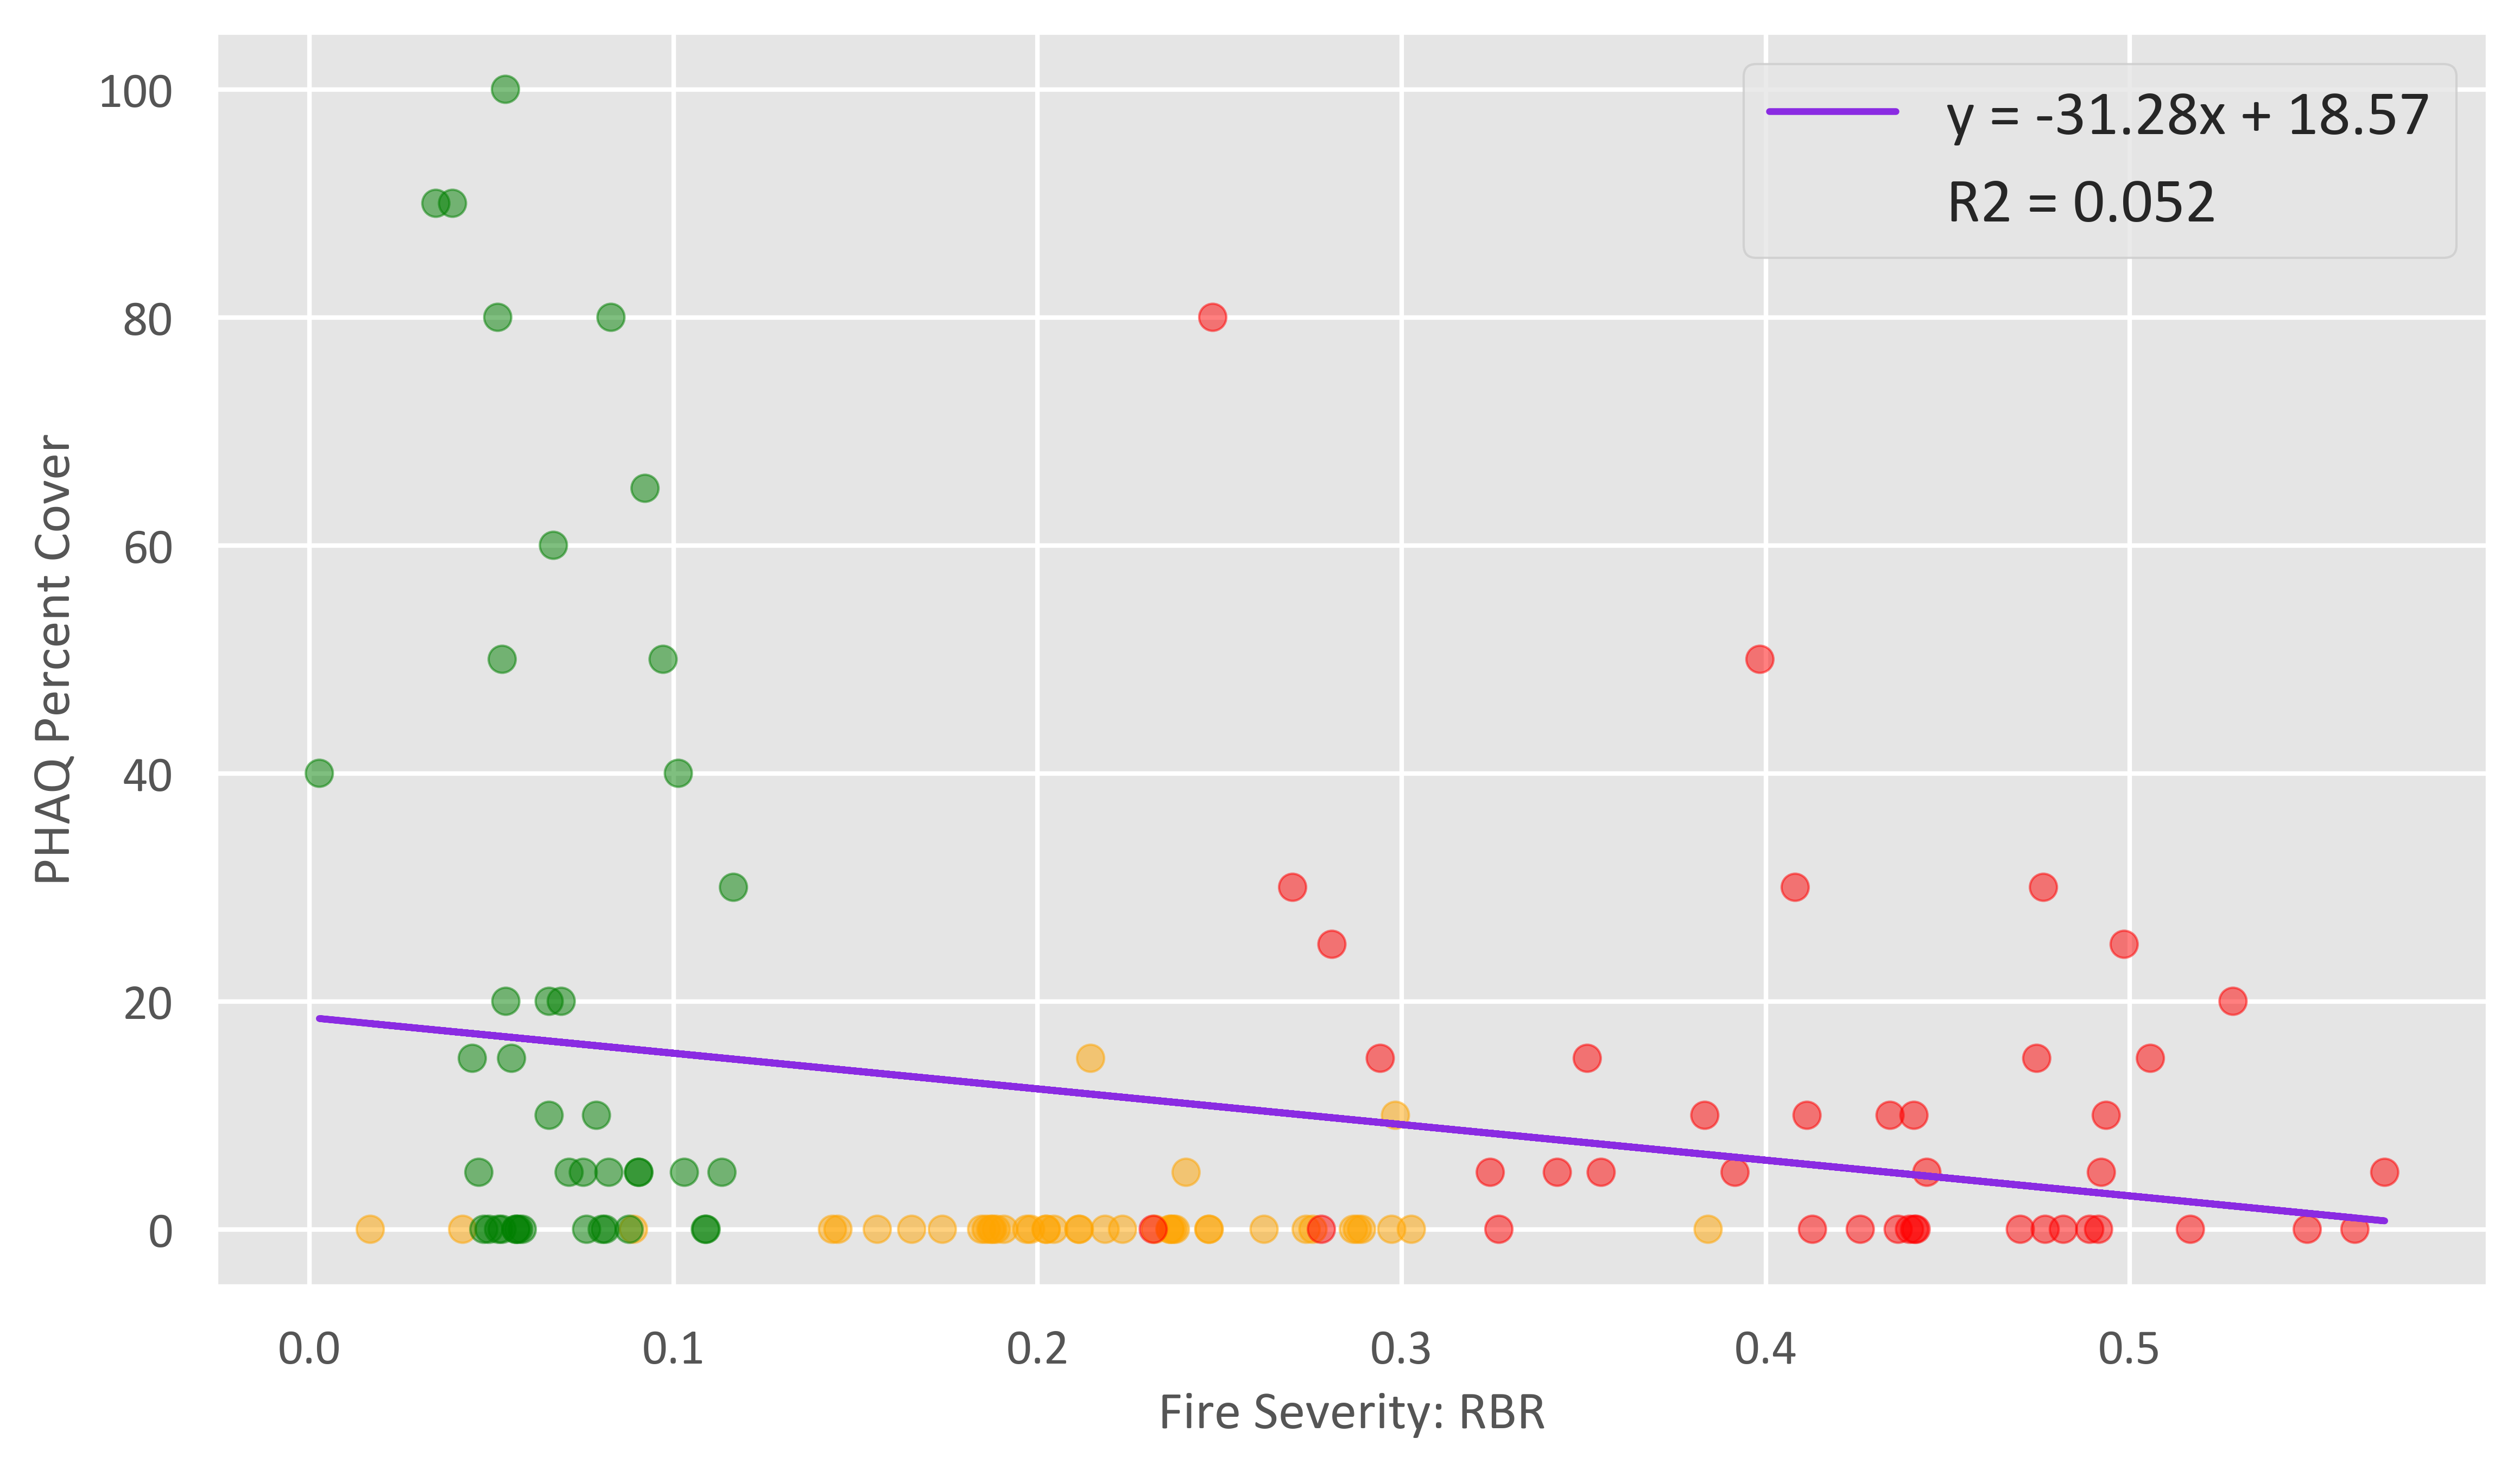

In [24]:
# What the LR used to look like
# get two sets of Xs and Ys to plot on same plot
X = data[fire]
y = data[plant]

model = sm.OLS(y, sm.add_constant(X)).fit()

# Print a summary of the regression results
# print(model.summary())
intercept, slope = model.params[0], model.params[1]

colors = {'NO':'green', 'RX':'orange', 'CZU':'red'}

plt.figure(figsize=(9,5), dpi=600)
# Create a scatter plot of the data and a line plot of the predicted values /color='teal', 
plt.scatter(X, y, alpha=0.5, c=data['Site'].map(colors))
plt.xlabel(f'Fire Severity: {fire}')
plt.ylabel(f'{plant} Percent Cover')
line = slope*X+intercept
plt.plot(X, line, 'blueviolet', label=f'y = {slope:.2f}x + {intercept:.2f}')
plt.plot([], [], ' ', label=f'R2 = {model.rsquared:.3f}') #add r2 as annotation on plot
plt.legend(fontsize=14)
plt.show()

## Polynomial Regression
using np model and seaborn to visualize SE

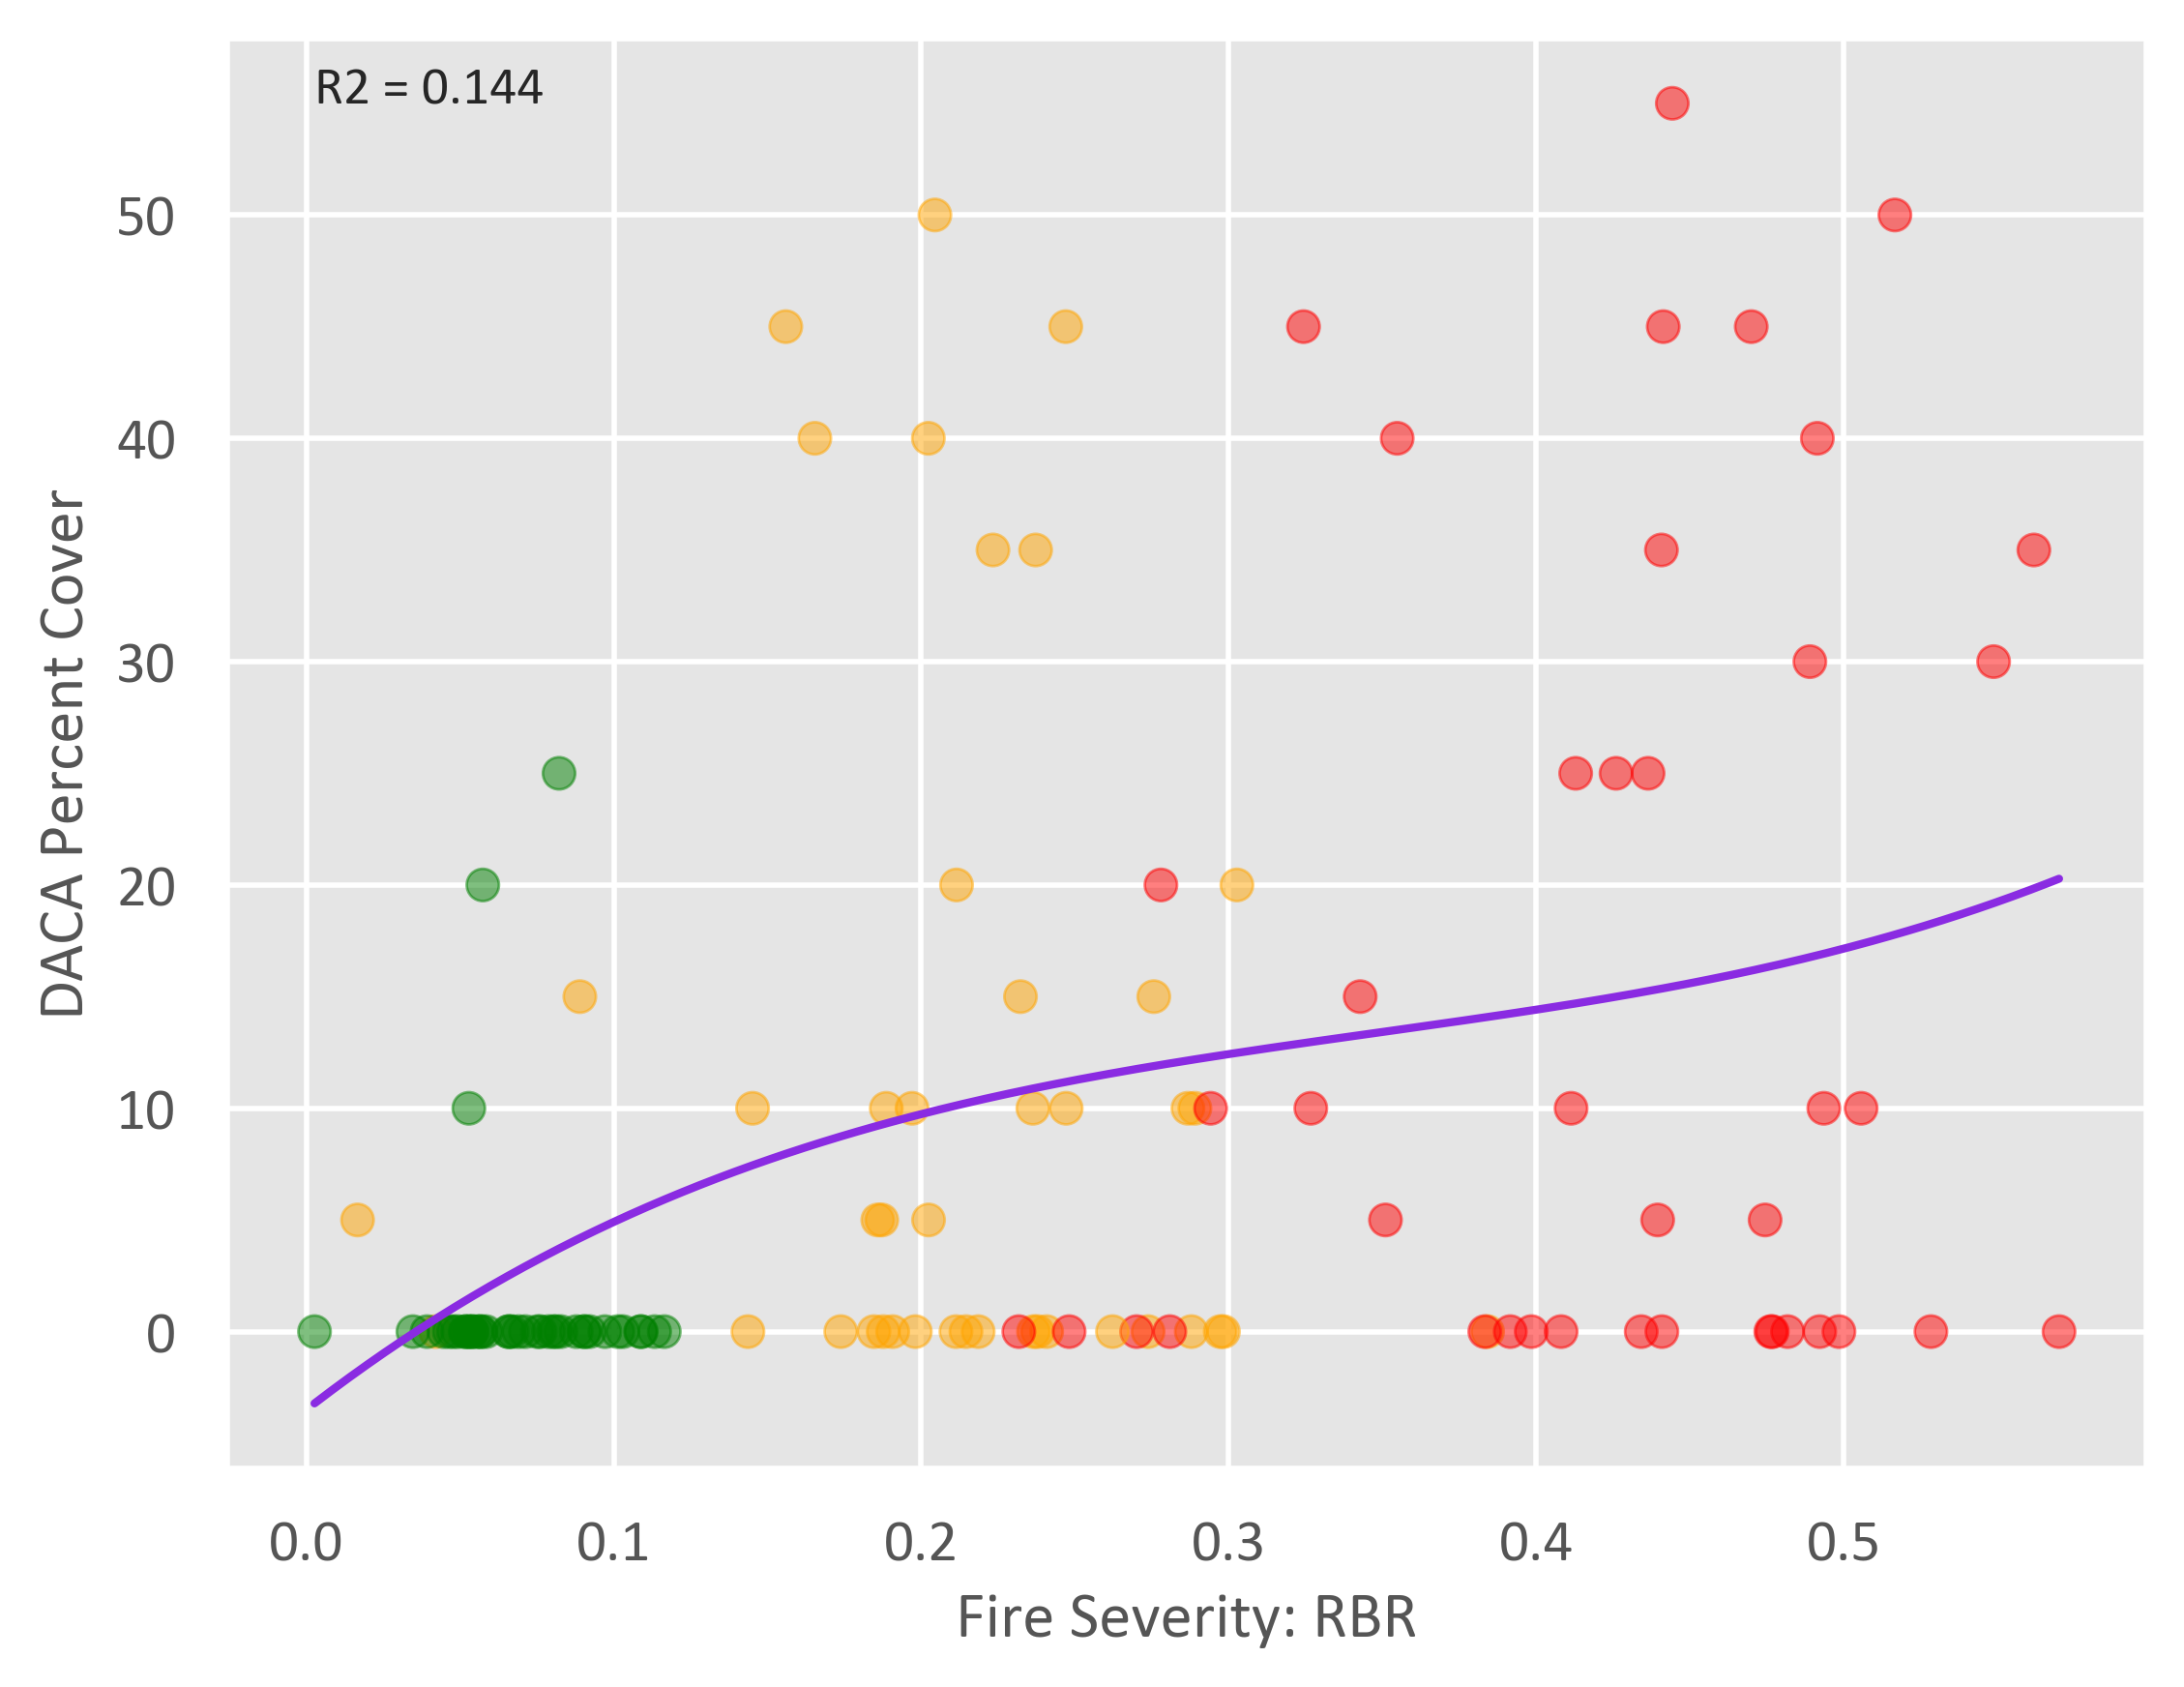

In [28]:
plt.style.use('ggplot') # I like 'ggplot' and 'seaborn-colorblind'
plt.rcParams['font.family'] = 'Calibri'

colors = {'NO':'green', 'RX':'orange', 'CZU':'red'}

fire = 'RBR' # dNBR or dBAI
plant = 'DACA' # 'ACMI','BAPI', 'CHPO', 'DACA', 'FRCA', 'MASA', 'PHAQ', 'PLLA', 'RUUR', 'HOLA', 'BRMA'
# or abundances i.e. Cultural Native Invasive Shrubs Herbaceous

X = np.array(data[fire])
y = np.array(data[plant])

# build polynomial regression model
prmodel = np.poly1d(np.polyfit(X, y, 3))
# build the predictive line
modelline = np.linspace(X.min(), X.max(), 300)

# plot the regression
plt.figure(dpi=400)
plt.scatter(X, y, alpha=0.5, c=data['Site'].map(colors)) #c='dodgerblue')
plt.plot(modelline, prmodel(modelline), 'blueviolet')
plt.xlabel(f'Fire Severity: {fire}')
plt.ylabel(f'{plant} Percent Cover')
plt.annotate(f'R2 = {r2_score(y, prmodel(X)):.3f}', (X.min(), y.max())) #add r2 as annotation on plot
# plt.legend()
plt.show()

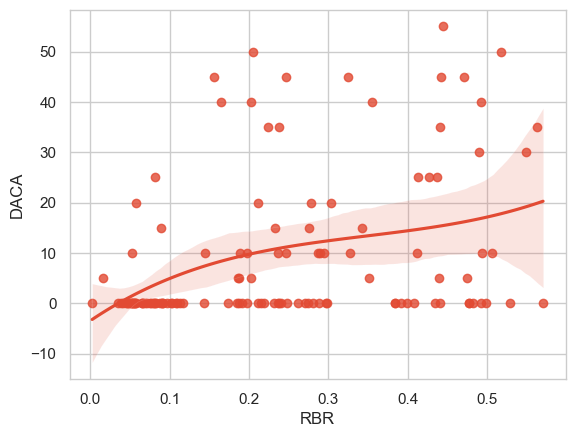

In [26]:
# seaborn visualizes the same polynomial regression with SE bars
# but no statistical outputs
sns.set_style('whitegrid')
fire = 'RBR'
sns.regplot(x=fire, y=plant, data=data, order=3)
plt.show()

#### Checking for colinearity and the distribution of the residuals

In [33]:
# # Plot histogram of residuals. compare the normal curve against your residuals KDE curve
# sns.distplot(model.resid, fit=stats.norm)
# plt.show()

# # looking for a symmetrical box plot, mean close to median
# sns.boxplot(x=model.resid, showmeans=True);

# # qq plot shows how 
# sm.qqplot(model.resid, line='s');

# plt.show()

### Fire severity of all plots - KW and Dunn tests

In [36]:
# make fire columns
rxfire = data.loc[data['Site'] == 'RX']
wildfire = data.loc[data['Site'] == 'CZU']
nofire = data.loc[data['Site'] == 'NO']
testcol='RBR'

# run anova
F, p = stats.f_oneway(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'ANOVA F-Statistic={F:.4f}, p={p:.4f}')

F, p = stats.kruskal(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'KW F-Statistic={F:.4f}, p={p:.4f}')

ANOVA F-Statistic=295.8864, p=0.0000
KW F-Statistic=99.9906, p=0.0000


In [37]:
# DUNN TEST
p_values = sp.posthoc_dunn(data, val_col=testcol, group_col='Site', sort=False)
# display(p_values)

# czu versus no, then czu vs rx, then no vs rx
p1 = p_values.loc['CZU', 'NO']
p2 = p_values.loc['CZU', 'RX']
p3 = p_values.loc['NO', 'RX']

reject = []
for p in [p1, p2, p3]:
    if p >= 0.05:
        reject.append("False - no sig diff")
    else:
        reject.append('True - sig diff')

print(testcol)
print(f'CZU versus NO fire, {reject[0]}, p_Holm = {p1:0.4f}')
print(f'CZU versus RX fire, {reject[1]}, p_Holm = {p2:0.4f}')
print(f'RX  versus NO fire, {reject[2]}, p_Holm = {p3:0.4f}')

RBR
CZU versus NO fire, True - sig diff, p_Holm = 0.0000
CZU versus RX fire, True - sig diff, p_Holm = 0.0000
RX  versus NO fire, True - sig diff, p_Holm = 0.0000


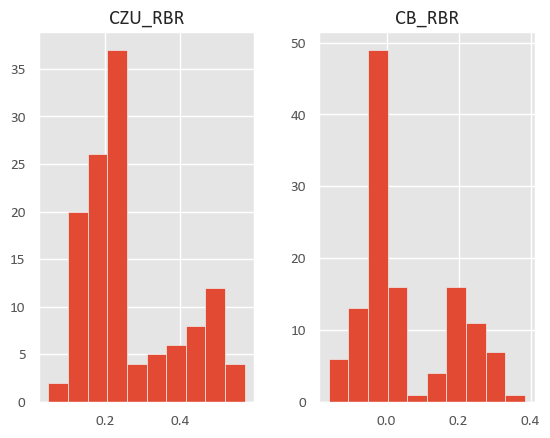

In [38]:
# checking distributions of each 
fs = data[['CZU_RBR', 'CB_RBR']]
histos = fs.hist()
plt.show()

### Fire severity of all pixels - KW and Dunn tests

In [39]:
file = 'D:/1_AMLT/7_CascadeBiodiversity/SentinelPixels_RBRvalues.csv'
sentinel = pd.read_csv(file)

In [40]:
data = sentinel

data = data.drop(columns=['Site'])
data = data.rename(columns={'SiteName': 'Site'})

# calc correct fire severity for each fire event
def RBR_calc(df):
    if df['Site'] == 'CZU':
        return df['CZU_RBR']
    elif df['Site'] == 'RX':
        return df['CB_RBR']
    else: #for no fire, return the mean of both fires
        return (df['CZU_RBR'] + df['CB_RBR'])/2
    

data['RBR'] = data.apply(RBR_calc, axis=1)
data.head(3)

,OID_,pointid,CZU_dNBR,CB_dNBR,Site,CB_RBR,CZU_RBR,RBR
0,1,2447,0.260550,-0.012450,NO,-0.010965,0.183835,0.086435
1,2,2448,0.201479,-0.003615,NO,-0.003205,0.150735,0.073765
2,3,2449,0.188780,0.005874,NO,0.005307,0.144382,0.074845


In [42]:
# Get averages for results section
# data.groupby('Site').mean()
# data.groupby('Site').std()

### Figure 4

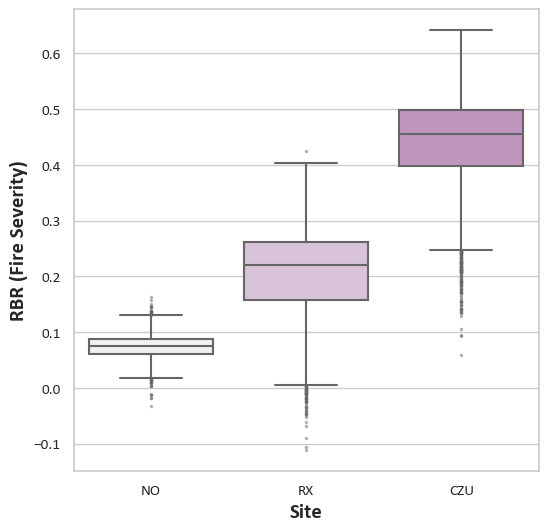

In [43]:
# boxplot
plt.style.use('ggplot') # I like 'ggplot' and 'seaborn-colorblind'
plt.rcParams['font.family'] = 'Calibri'

# sns.color_palette = 'white'
sns.set_theme(style='whitegrid', palette='light:purple', font='Calibri')
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.boxplot(data=data, x='Site', y='RBR', flierprops = {'marker': 'o', 'markersize':1.5, 'alpha':0.4})

ax.set_ylabel('RBR (Fire Severity)', fontweight ='bold', size = 15)
ax.set_xlabel('Site', fontweight ='bold', size = 15)
# https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette

# filename = 'D:/1_AMLT/7_CascadeBiodiversity/Maps_Figures/Figure4_RBRboxplot.png'
# plt.savefig(filename, format="png", dpi=600)

plt.show()

#### ANOVA/KW of all pixels fire severity

<AxesSubplot: xlabel='RBR', ylabel='Count'>

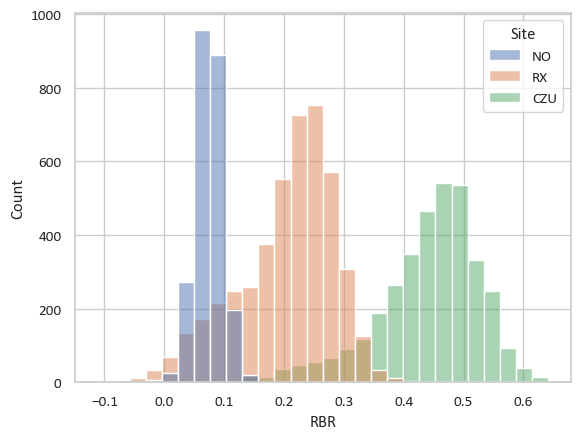

In [44]:
# checking distributions of each 
sns.set_theme(style='whitegrid', palette='deep', font='Calibri')
sns.histplot(data=data, x='RBR', hue='Site')

In [45]:
# make fire columns
rxfire = data.loc[data['Site'] == 'RX']
wildfire = data.loc[data['Site'] == 'CZU']
nofire = data.loc[data['Site'] == 'NO']

testcol = 'RBR'

# test normality
# print(stats.shapiro(nofire[testcol]))

# run anova
F, p = stats.f_oneway(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'ANOVA F-Statistic={F:.4f}, p={p:.4f}')

F, p = stats.kruskal(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'KW F-Statistic={F:.4f}, p={p:.4f}')

ANOVA F-Statistic=19149.8184, p=0.0000
KW F-Statistic=7930.4346, p=0.0000


In [46]:
# DUNN TEST
p_values = sp.posthoc_dunn(data, val_col=testcol, group_col='Site', sort=False)
# display(p_values)

# czu versus no, then czu vs rx, then no vs rx
p1 = p_values.loc['CZU', 'NO']
p2 = p_values.loc['CZU', 'RX']
p3 = p_values.loc['NO', 'RX']

reject = []
for p in [p1, p2, p3]:
    if p >= 0.05:
        reject.append("False - no sig diff")
    else:
        reject.append('True - sig diff')

print(testcol)
print(f'CZU versus NO fire, {reject[0]}, p_Holm = {p1:0.4f}')
print(f'CZU versus RX fire, {reject[1]}, p_Holm = {p2:0.4f}')
print(f'RX  versus NO fire, {reject[2]}, p_Holm = {p3:0.4f}')

RBR
CZU versus NO fire, True - sig diff, p_Holm = 0.0000
CZU versus RX fire, True - sig diff, p_Holm = 0.0000
RX  versus NO fire, True - sig diff, p_Holm = 0.0000


### Timeline figure (figure 2)

In [47]:
fires = pd.DataFrame([
        {"start": dt.datetime(2020, 8, 2), "end": dt.datetime(2020, 8, 3), "Event": "Sentinel-2 Images"},
        {"start": dt.datetime(2020, 9, 26), "end": dt.datetime(2020, 9, 27), "Event": "Sentinel-2 Images"},
        {"start": dt.datetime(2020, 11, 15), "end": dt.datetime(2020, 11, 16), "Event": "Sentinel-2 Images"},
        {"start": dt.datetime(2020, 11, 25), "end": dt.datetime(2020, 11, 26), "Event": "Sentinel-2 Images"},
        {"start": dt.datetime(2020, 8, 16), "end": dt.datetime(2020, 9, 22), "Event": "CZU Wildfire"},
        {"start": dt.datetime(2020, 11, 19), "end": dt.datetime(2020, 11, 20), "Event": "Controlled Fire"}
    ])

# colors = ['#7fc97f','#beaed4','#fdc086']

fireschart = alt.Chart(fires).mark_bar(size=100).encode(
    x='start:T',
    x2='end:T',
    y='Event',
    color=alt.Color('Event', scale=alt.Scale(range=['#870e05','#e09509','#095594']), legend=None)
)


fireschart.encoding.x.title = 'Date (2020)'
fireschart.encoding.y.title = None

fireschart.properties(width=1000, height=325).configure(
    font='Calibri',
    padding={"left": 30, "top": 30, "right": 50, "bottom": 30}
).configure_legend( #I'm not using this legend
    strokeColor='gray',
    fillColor='#EEEEEE', 
    padding=10,
    cornerRadius=10,
    labelFontSize=22,
    title = None
).configure_axis(labelFontSize = 23, titleFontSize=24).configure_view(stroke='darkgrey', fill='#f5f7fa')

# filename = 'D:/1_AMLT/7_CascadeBiodiversity/Maps_Figures/Figure2_Timeline.png'
# fireschart.save('Figure2.png', engine="altair_saver", scale_factor=2.0)
# fireschart.save('Figure2.pdf')


alt.Chart(...)